# Quant Test
Haohang Li  
May 12, 2021

#### Dependicies & Set up:

In [1]:
import os
import concurrent.futures
import pyEX as p
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import log, exp

# IEXcloud.io api token:
the_token = 'pk_11aed73364324c4f8ae2897e9ee655c0'

# path
if not os.path.isdir('data'):
    os.mkdir('data')
    os.mkdir('data/raw')

## Download Data

Load S&P 500 constituents csv and subset the industrials, health care, consumer discretionary sectors:

In [2]:
# load
constituents = pd.read_csv('https://datahub.io/core/s-and-p-500-companies/r/constituents.csv')

# subset
condition = constituents['Sector'] == 'Industrials'
condition2 = constituents['Sector'] == 'Health Care'
condition3 = constituents['Sector'] == 'Consumer Discretionary'
constituents_sub = constituents[condition | condition2 | condition3]

constituents_sub.head()

,Symbol,Name,Sector
0,MMM,3M Company,Industrials
1,AOS,A.O. Smith Corp,Industrials
2,ABT,Abbott Laboratories,Health Care
3,ABBV,AbbVie Inc.,Health Care
4,ABMD,Abiomed,Health Care


Download data from IEXcloud.io:

In [3]:
# download data function
def download_data(the_symbols, the_sector, the_timeframe, the_api_token, save_path, num_workers=4):
    """
    Download data from IEXcloud.io. and save to path
    
    Args:
        the_symbols(list): a list of symbols to be downloaded
        the_sector(str): the sector of downloaded symbols
        the_timeframe(str): the timeframe of data, chose from 
                            ['max', '5y', '2y', '1y', 'ytd', '6m', '3m', '1m', '1mm', '5d', '5dm', '1d', 'dynamic']
        the_api_token(str): the token from IEXcloud.io
        num_workers(int): the number of threads
    
    Returns:
        pd.DataFrame: downloaded data for all symbols
    """
    
    # define download one symbol function
    def download_one(args):
        """
        Function to download data for one symbol, will be distributed to different threads, save to path
        
        Args:
            args[0]: symbol
            args[1]: timeframe
            args[2]: the sector
            args[3]: save path
            
        Returns:
            pd.Dataframe: data for one symbol
        """
        
        result = c.chartDF(symbol=args[0], timeframe=args[1], filter='date, symbol, open, high, low, close')
        result.insert(1, 'sector', [args[2]] * result.shape[0])
        result.reset_index(inplace=True)
        result.to_csv(os.path.join(args[3], args[0] + '.csv'))

        return result

    # initialize api client
    c = p.Client(api_token=the_api_token)
    # distribute task to threads
    arguments = [(i, the_timeframe, the_sector, save_path) for i in the_symbols]  # (symbol, timeframe, sector, path)
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as e:
        results = list(e.map(download_one, arguments))
    # concat
    result = pd.concat(results, ignore_index=True)

    return result

In [4]:
# download data
# extract symbols
symbols_industrials = constituents_sub[constituents_sub['Sector'] == 'Industrials']['Symbol'].to_list()
symbols_healthCare = constituents_sub[constituents_sub['Sector'] == 'Health Care']['Symbol'].to_list()
symbols_consumerDis = constituents_sub[constituents_sub['Sector'] == 'Consumer Discretionary']['Symbol'].to_list()

# download
save_path = os.path.join(os.getcwd(), 'data', 'raw')
data_industrials = download_data(the_symbols=symbols_industrials,
                                the_sector='Industrials',
                                the_timeframe='5y',
                                the_api_token=the_token,
                                save_path=save_path)
data_healthCare = download_data(the_symbols=symbols_healthCare,
                                the_sector='Health Care',
                                the_timeframe='5y',
                                the_api_token=the_token,
                                save_path=save_path)
data_consumerDis = download_data(the_symbols=symbols_consumerDis,
                                the_sector='Consumer Discretionary',
                                the_timeframe='5y',
                                the_api_token=the_token,
                                save_path=save_path)


# set index 
data_industrials.set_index(['date', 'symbol', 'sector'], inplace=True)
data_industrials.sort_index(inplace=True)
data_healthCare.set_index(['date', 'symbol', 'sector'], inplace=True)
data_healthCare.sort_index(inplace=True)
data_consumerDis.set_index(['date', 'symbol', 'sector'], inplace=True)
data_consumerDis.sort_index(inplace=True)

# save data
data_industrials.to_csv(os.path.join(os.getcwd(), 'data', 'industrials.csv'))
data_healthCare.to_csv(os.path.join(os.getcwd(), 'data', 'healthcare.csv'))
data_consumerDis.to_csv(os.path.join(os.getcwd(), 'data', 'consumer.csv'))

# show sample
data_industrials

open      high      low    close
date       symbol sector                                          
2016-05-13 AAL    Industrials   31.090   32.0100   31.080   31.510
           ALK    Industrials   65.720   67.1400   65.500   66.260
           ALLE   Industrials   66.010   66.9400   65.560   66.010
           AME    Industrials   46.790   47.0650   46.030   46.320
           AOS    Industrials   39.225   39.7850   38.895   39.125
...                                ...       ...      ...      ...
2021-05-12 URI    Industrials  340.340  343.2899  328.020  329.290
           VRSK   Industrials  172.520  174.3100  171.250  172.000
           WAB    Industrials   79.660   79.9200   77.480   77.720
           WM     Industrials  140.920  141.0100  138.120  138.180
           XYL    Industrials  117.100  117.5000  112.600  112.980

[90878 rows x 4 columns]

## Return series:

Return function:

In [5]:
def make_ret(df, long: bool=True) -> pd.Series:
    """Generates returns.

    Args:
        df (Pandas Dataframe or Series): A series or dataframe of daily close prices.
        long (bool, optional): True indicates long-only, False is for short-only. Defaults to True.
        
    Returns:
        pd.Series: cumulative daily returns, from logged daily close prices.
    """    
    
    if long:
        sign = 1
    else:
        sign = -1

    ret = (
        sign*log(df)
        .groupby(level=1)
        .diff()
        .groupby(level=0)
        .mean()
        .cumsum()
    )
    return ret

Load data: (optional)

In [6]:
# load data
data_industrials = pd.read_csv(os.path.join(os.getcwd(), 'data', 'industrials.csv'), parse_dates=[0])
data_healthCare = pd.read_csv(os.path.join(os.getcwd(), 'data', 'healthcare.csv'), parse_dates=[0])
data_consumerDis = pd.read_csv(os.path.join(os.getcwd(), 'data', 'consumer.csv'), parse_dates=[0])

# set index 
data_industrials.set_index(['date', 'symbol', 'sector'], inplace=True)
data_industrials.sort_index(inplace=True)
data_healthCare.set_index(['date', 'symbol', 'sector'], inplace=True)
data_healthCare.sort_index(inplace=True)
data_consumerDis.set_index(['date', 'symbol', 'sector'], inplace=True)
data_consumerDis.sort_index(inplace=True)

Return for long only Strategy:

In [7]:
return_long = make_ret(df=data_industrials['close'], long=True)

Return for long + short

In [8]:
return_longShort = make_ret(df=data_healthCare['close'], long=True) + make_ret(df=data_consumerDis['close'], long=False)

Plot:

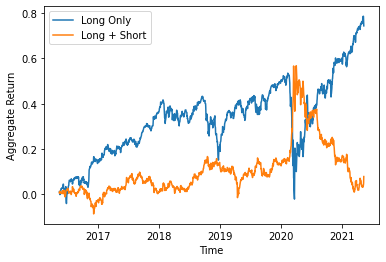

In [9]:
fig, ax = plt.subplots()
ax.plot(return_long,label='Long Only')
ax.plot(return_longShort, label='Long + Short')
plt.xlabel('Time')
plt.ylabel('Aggregate Return')
plt.legend()
plt.show()

## Sharpe, Sortino, and Information Ratio statistics

Calculations are based on https://am.jpmorgan.com/hk/en/asset-management/adv/tools-resources/investment-glossary/  
and http://www.redrockcapital.com/Sortino__A__Sharper__Ratio_Red_Rock_Capital.pdf

In long+short strategy, for simplicity, we assume we invest same amount of money on long side and short side.

Helper functions:

In [10]:
def simple_return(df, long=True):
    """
    Caculate the simple return from the close price series

    Args:
        df(pd.Dataframe): daily close price series
        long(bool): true for the long strategy, false for short strategy

    Returns:
        pd.Series: daily simple return series
    """

    sign = 1 if long else -1

    return sign * (exp(log(df.groupby(level=0).mean()).diff()) - 1)

def annual_to_daily(the_return_series):
    """
    Convert the annual return to daily return

    Args:
        the_return_series(pd.Series): annual simple return series
    
    Returns:
        pd.Series: the daily return series
    """

    return the_return_series.apply(lambda x: exp(log(x + 1) / 365) - 1)


def simple_to_log(the_return_series):
    """
    Convert the simple return to log return series

    Args:
        the_return_series(pd.Series): simple return series
    
    Returns:
        pd.Series: the log return series
    """
    
    return the_return_series.apply(lambda x: log(x + 1))

Sharpe Ratio:  
$$\text{Sharpe Ratio} = \frac{R_P - R_f} {\sigma_P}$$

In our case, we assume the annual risk free return is 5%.

In [11]:
# sharpe ratio function
def sharpe_ratio_annualized(the_return, the_risk_free):
    
    """
    Calculate the portfolio sharpe ratio from daily return, the return is measured as arithmetic return.

    portfolio sharpe ratio = mean(portfolio return - risk free rate) / std(portfolio return - risk free rate)

    The result is annualized.

    Args:
        the_return(pd.Series): the daily return series of the portfolio, arithmetic return
        the_risk_free(pd.Series): the daily return series of risk free rate, arithmetic return

    Returns:
        float: the annualized portfolio sharpe ratio
    """

    # calculate the excessive return
    ex_ret = the_return - the_risk_free

    # sharpe ratio
    sharpe = ex_ret.mean() / ex_ret.std()

    # annualized
    sharpe = sharpe * np.sqrt(252)

    return sharpe

# in some case the sharpe ratio is measured in log returns
def sharpe_ratio_annualized_log(the_return, the_risk_free):

    """
    Calculate the portfolio sharpe ratio from daily return, the return is measured as log return

    portfolio sharpe ratio = mean(portfolio return - risk free rate) / std(portfolio return - risk free rate)
    
    The result is annualized.

    Args:
        the_return(pd.Series): the daily return series of the portfolio, log return
        the_risk_free(pd.Series): the daily return series of risk free rate, log return

    Returns:
        float: the annualized portfolio sharpe ratio
    """

    # calculate the excessive return
    ex_ret = simple_to_log(the_return) - simple_to_log(the_risk_free)

    # sharpe ratio
    sharpe = ex_ret.mean() / ex_ret.std()

    # annualized
    sharpe = sharpe * np.sqrt(252)

    return sharpe

# risk free rate series
rfr_series = pd.Series([0.05] * return_long.shape[0], index=return_long.index)
rfr_series = annual_to_daily(rfr_series)

# long strategy sharpe ratio
long_simple_ret = simple_return(data_industrials['close'])
long_sharpe_ratio = sharpe_ratio_annualized(long_simple_ret, rfr_series)
long_sharpe_ratio_log = sharpe_ratio_annualized_log(long_simple_ret, rfr_series)
# long+short strategy sharpe ratio
longShort_simple_ret = simple_return(data_healthCare['close'], long=True) + simple_return(data_consumerDis['close'], long=False)
longShort_sharpe_ratio = sharpe_ratio_annualized(longShort_simple_ret, rfr_series)
longShort_sharpe_ratio_log = sharpe_ratio_annualized_log(longShort_simple_ret, rfr_series)

# show
print(f'The sharpe ratio for long strategy is {long_sharpe_ratio:.5f}.')
print(f'The sharpe ratio for long+short strategy is {longShort_sharpe_ratio:.5f}.')
print(f'The sharpe ratio(log) for long strategy is {long_sharpe_ratio_log:.5f}.')
print(f'The sharpe ratio(log) for long+short strategy is {longShort_sharpe_ratio_log:.5f}.')

The sharpe ratio for long strategy is 0.65249.
The sharpe ratio for long+short strategy is -0.31457.
The sharpe ratio(log) for long strategy is 0.53937.
The sharpe ratio(log) for long+short strategy is -0.38946.


Sortino Ratio:
$$\text{Sortino Ratio} = \frac{R_p - R_f} {\sigma_d}$$
where the $\sigma_d$ is the downside standard deviation.

In [12]:
# sortino ratio function
def sortino_ratio_annualized(the_return, the_risk_free):

    """
    Calculate the portfolio sortino ratio from daily return

    portfolio sortino ratio = mean(portfolio return - risk free rate) / downside_std(portfolio return - risk free rate)

    The result is annualized.

    Args:
        the_return(pd.Series): the daily return series of the portfolio, arithmetic return
        the_risk_free(pd.Series): the daily return series of risk free rate, arithmetic return

    Returns:
        float: the annualized portfolio sortino ratio
    """

    # calculate the excessive return
    ex_ret = the_return - the_risk_free

    # subset the downside return: keep the negative and replace positive to 0
    down_ret = ex_ret.apply(lambda x: 0 if x > 0 else x)

    # sortino ratio
    sortino = ex_ret.mean() / down_ret.std()

    # annualized
    sortino = sortino * np.sqrt(252)

    return sortino

# long strategy sortino ratio
long_sortino_ratio = sortino_ratio_annualized(long_simple_ret, rfr_series)
# long+short strategy sortino ratio
longShort_sortino_ratio = sortino_ratio_annualized(longShort_simple_ret, rfr_series)

# show
print(f'The sortino ratio for long strategy is {long_sortino_ratio:.5f}')
print(f'The sortino ratio for long+short strategy is {longShort_sortino_ratio:.5f}')

The sortino ratio for long strategy is 0.97964
The sortino ratio for long+short strategy is -0.50052


Information Ratio:
$$\text{Information Ratio}=\frac{R_p - R_b}{\sigma_{pb}}$$


We will use S&P 500 as our benchmark.

In [13]:
# information ratio
def information_ratio_annualized(the_return, the_benchmark):

    """
    Calculate the portfolio information ratio from daily return

    portfolio information ratio = mean(portfolio return - benchmark return) / std(portfolio return - benchmark return)

    The result is annualized.

    Args:
        the_return(pd.Series): the daily return series of the portfolio, arithmetic return
        the_benchmark(pd.Series): the daily return series of the benchmark asset, arithmetic return

    Returns:
        float: the annualized portfolio information ratio
    """
    
    # calculate the difference between benchmark and portfolio
    diff_ret = the_return - the_benchmark

    # information ratio
    information = diff_ret.mean() / diff_ret.std()

    # annualized
    information = information * np.sqrt(252)

    return information

# S&P 500 daily return
sp500_close = p.Client(api_token=the_token).chartDF(symbol='SPY', timeframe='5y', filter='date, close')
sp500_close.sort_index(inplace=True)
sp500_ret = exp(log(sp500_close['close']).diff()) - 1

# long strategy information ratio
long_information_ratio = information_ratio_annualized(long_simple_ret, sp500_ret)
# long+short strategy information ratio
longShort_information_ratio = information_ratio_annualized(longShort_simple_ret, sp500_ret)

# show
print(f'The information ratio for long strategy is {long_information_ratio:.5f}')
print(f'The information ratio for long+short strategy is {longShort_information_ratio:.5f}')

The information ratio for long strategy is 0.23395
The information ratio for long+short strategy is -0.68121
